In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Creating DataFrame

def df_multiple_csv(path, app):
    path += app + '*.csv'
    files = glob.glob(path)
    files.sort()
    dfdict = {}
    for idx, f in enumerate(files):
        dfdict[f'df{idx}'] = pd.read_csv(f, index_col=0)
    return dfdict

path = '/home/ilkin/Repos/datasci/london/'
dfdict = df_multiple_csv(path, 'postcodes/')
df = pd.DataFrame()
for d in dfdict.values():
    df = pd.concat([df, d])
lookups = pd.read_csv(path + 'postcodes/lookup/' + 'ukpostcodes.csv', index_col=1)
lookups.drop(columns=['id'], inplace=True)
lookups.index = lookups.index.str.replace(' ', '')
df.index = df.index.str.replace(' ', '')
df = df.join(lookups)
df.drop(columns=['Males', 'Females', 'Occupied_Households'], inplace=True)
df

,Total,latitude,longitude
Postcode,,,
AL11AG,14,51.745290,-0.328628
AL11AJ,124,51.744498,-0.328599
AL11AR,32,51.739727,-0.317484
AL11AS,34,51.749073,-0.335471
AL11BH,52,51.746852,-0.338000
...,...,...,...
YO89YA,23,53.770419,-1.158828
YO89YB,33,53.770000,-1.159352
YO89YD,9,53.769733,-1.171313


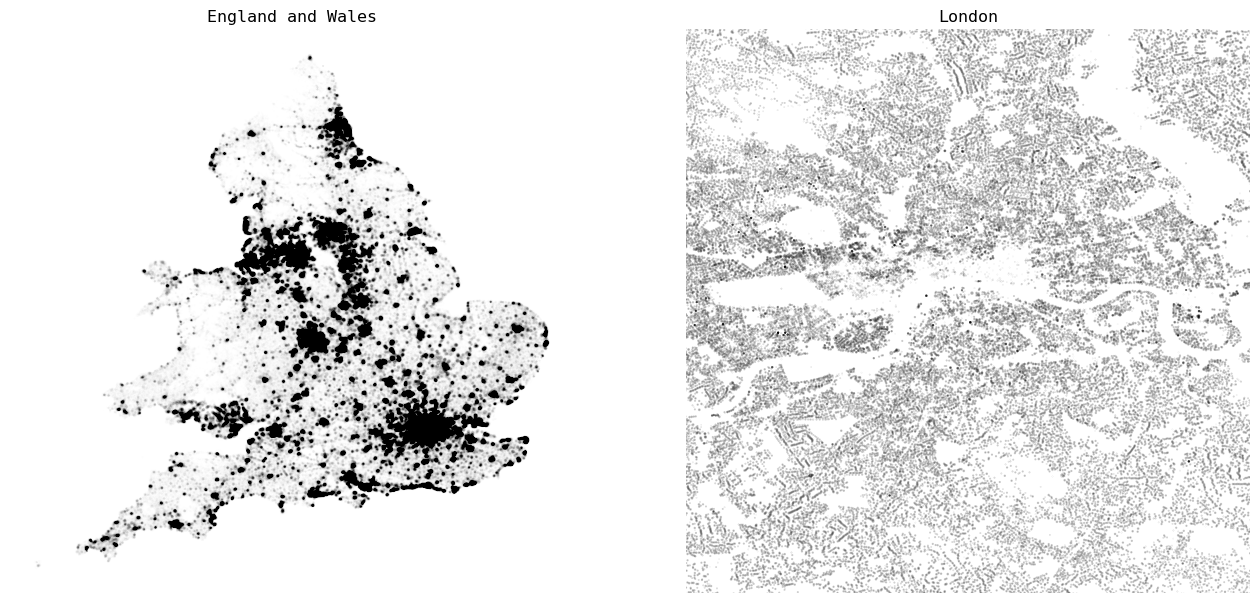

In [10]:
# Preliminary plots

fig, ax = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

titles = ['England and Wales', 'London']
for coeff, a in enumerate(ax):
    a.set_title(titles[coeff], fontname='monospace')
    coeff -= 2
    coeff = abs(coeff)
    coeff *= coeff**2
    a.scatter(df['longitude'], df['latitude'], s=df['Total'] / 150 * coeff, alpha=0.2 * coeff ** (-2), c='k')
    a.set_box_aspect(1)
    a.axis('off')

ax[1].set_xlim([-0.2, 0.0])
ax[1].set_ylim([51.4, 51.6])
plt.show()

fig.savefig('plots/prelim2.png', bbox_inches='tight')

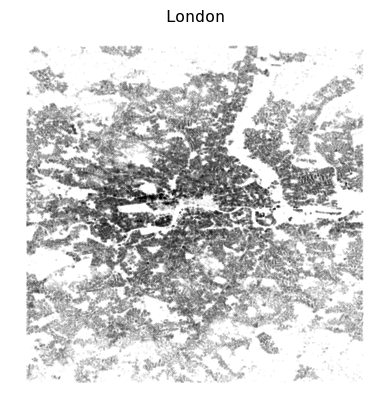

In [3]:
# Subsection of df on London

nf = df.copy()
nf = nf[np.logical_and(nf['latitude']>51.3, nf['latitude']<51.7)]
nf = nf[np.logical_and(nf['longitude']>-0.3, nf['longitude']<0.1)]
plt.scatter(nf['longitude'], nf['latitude'], s=nf['Total']/1000, alpha=0.2, c='k')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.title('London', fontname='monospace')
plt.show()

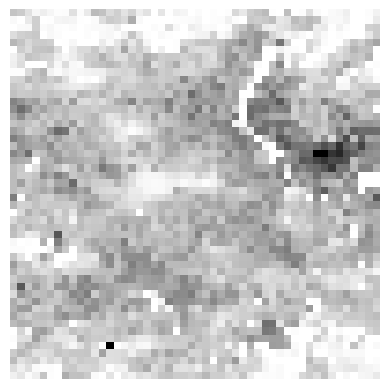

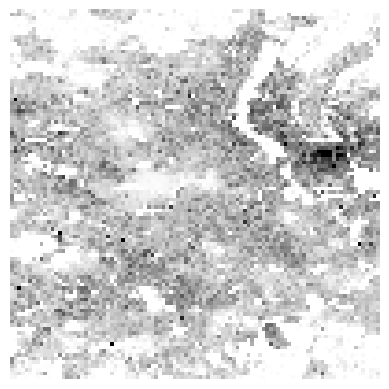

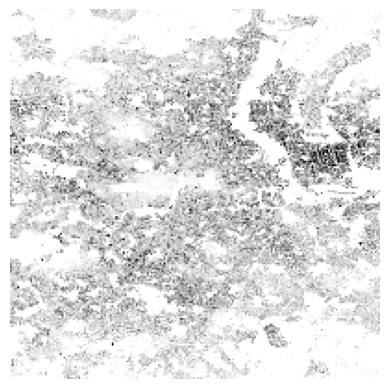

In [4]:
def mat_hist(nf, latlim, lonst, matsize):
    mat = np.zeros((matsize, matsize))
    df = pd.DataFrame()
    rng = latlim[1] - latlim[0]
    inc = rng / matsize
    latst = latlim[0]
    for i in range(matsize):
        for j in range(matsize):
            df = nf[np.logical_and(nf['latitude']>(latst + inc*i), nf['latitude']<(latst + inc*(i+1)))]
            df = df[np.logical_and(df['longitude']>(lonst + inc*j), df['longitude']<(lonst + inc*(j+1)))]
            series = df['Total']
            val = series.sum() / (len(series) + 1)
            valid = val < 140
            mat[-i-1, j] = valid * val + abs(valid - 1) * 150
    return mat

def plot_save(res):
    mat = mat_hist(nf, (51.3, 51.7), -0.3, res)
    np.save(f'np/mat{res}', mat)
    plt.imshow(mat, cmap='Greys')
    plt.axis('off')
    plt.show()

plot_save(50)
plot_save(100)
plot_save(200)

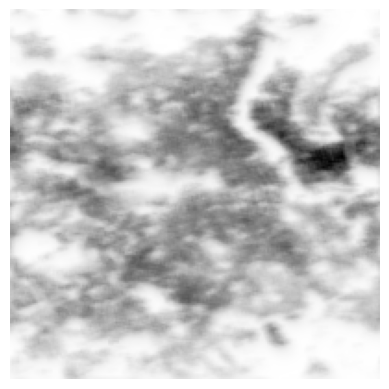

In [107]:
def smooth(mat, matsize, deg):
    mat1 = np.copy(mat)
    for i in range(matsize):
        for j in range(matsize):
            xr = np.r_[i - deg : i + deg] % matsize
            xc = np.r_[j - deg : j + deg] % matsize
            mat1[i, j] = np.mean(mat1[np.ix_(xr, xc)])
    return mat1

smoothed = smooth(mat, 200, 3)
plt.imshow(mat1, cmap='Greys')
plt.axis('off')
plt.show()

In [138]:
def threedim(deg1, deg2, mat):
    x = y = np.arange(200)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(-X, Y, -mat, rstride=1, cstride=1, cmap='Greys_r', linewidth=0, antialiased=False)
    plt.axis('off')
    ax.view_init(deg1, deg2)
    plt.show()

# threedim(90, 90)
threedim(60, 160, smooth(mat, 200, 5))
threedim(80, 180, smooth(mat, 200, 1))